Sage attention seems to have really significant error for the SM 9.0 version. This happens to the latest main branch, 2.2.0 version released as of Nov 2025.

In [1]:
%cd /home/ubuntu/Qwen-Image-Edit-Angles

/home/ubuntu/Qwen-Image-Edit-Angles


In [2]:
#!/usr/bin/env python3
import time
import torch
import torch.nn.functional as F
from torch.nn.attention import SDPBackend, sdpa_kernel
from sageattention import (
    sageattn_qk_int8_pv_fp16_cuda, 
    sageattn_qk_int8_pv_fp16_triton, 
    sageattn_qk_int8_pv_fp8_cuda, 
    sageattn_qk_int8_pv_fp8_cuda_sm90
)
import numpy as np
import matplotlib.pyplot as plt
from collections import defaultdict

# Import Flash Attention 3
try:
    from kernels import get_kernel
    _k = get_kernel("kernels-community/vllm-flash-attn3")
    _flash_attn_func = _k.flash_attn_func
    FA3_AVAILABLE = True
except Exception as e:
    _flash_attn_func = None
    FA3_AVAILABLE = False
    print(f"Flash Attention 3 not available: {e}")


def calculate_tolerance_metrics(actual, expect):
    """Calculate tolerance metrics between actual and expected outputs."""
    actual = actual.float()
    expect = expect.float()
    diff = (actual - expect).abs()
    eps = torch.tensor(
        torch.finfo(actual.dtype).eps, device=actual.device, dtype=actual.dtype
    )
    rdiff = diff / torch.maximum(torch.maximum(actual.abs(), expect.abs()), eps)
    return {
        "mean_relative_tolerance": rdiff.mean().item(),
        "max_relative_tolerance": rdiff.max().item(),
        "mean_absolute_tolerance": diff.mean().item(),
        "max_absolute_tolerance": diff.max().item(),
        "mse": F.mse_loss(actual, expect).item()
    }


def flash_attn3_wrapper(q, k, v):
    """
    Wrapper for Flash Attention 3 that matches the SageAttention interface.
    FA3 expects (batch, seq_len, num_heads, head_dim)
    SageAttention provides (batch, num_heads, seq_len, head_dim)
    """
    # Transpose from (B, H, S, D) to (B, S, H, D)
    q = q.transpose(1, 2)
    k = k.transpose(1, 2)
    v = v.transpose(1, 2)
    
    # Call FA3
    outputs, _ = _flash_attn_func(q, k, v, causal=False)
    
    # Transpose back to (B, H, S, D)
    outputs = outputs.transpose(1, 2)
    return outputs


# Test configuration
batch_size = 4
head_num = 32
seq_len = 64
head_dim = 128
dtype = torch.float16
num_inputs = 100

print(f"Running tests with {num_inputs} inputs...")
print(f"Config: batch_size={batch_size}, head_num={head_num}, seq_len={seq_len}, head_dim={head_dim}, dtype={dtype}")
print("-" * 80)

# Define attention implementations to test
attention_types = {
    "SDPA (Flash)": lambda q, k, v: F.scaled_dot_product_attention(q, k, v),
    "SageAttn QK-INT8 PV-FP16 CUDA": sageattn_qk_int8_pv_fp16_cuda,
    "SageAttn QK-INT8 PV-FP16 Triton": sageattn_qk_int8_pv_fp16_triton,
    "SageAttn QK-INT8 PV-FP8 CUDA": sageattn_qk_int8_pv_fp8_cuda,
    "SageAttn QK-INT8 PV-FP8 CUDA SM90": sageattn_qk_int8_pv_fp8_cuda_sm90,
}

# Add Flash Attention 3 if available
if FA3_AVAILABLE:
    attention_types["Flash Attention 3"] = flash_attn3_wrapper

# Storage for metrics and runtimes across all inputs
all_metrics = {name: defaultdict(list) for name in attention_types.keys()}
all_runtimes = {name: [] for name in attention_types.keys()}

# Enable math backend for ground truth
torch.backends.cuda.enable_math_sdp(True)

# Run tests for 100 inputs
for i in range(num_inputs):
    # Generate random input
    q = torch.randn(batch_size, head_num, seq_len, head_dim, device="cuda", dtype=dtype)
    k = torch.randn_like(q)
    v = torch.randn_like(q)
    
    # Get ground truth using mathematically correct implementation
    with sdpa_kernel(SDPBackend.MATH):
        out_math = F.scaled_dot_product_attention(q, k, v)
    
    # Test each attention type
    for name, attn_fn in attention_types.items():
        try:
            # Measure runtime
            torch.cuda.synchronize()
            start_time = time.perf_counter()
            
            if name == "SDPA (Flash)":
                with sdpa_kernel(SDPBackend.FLASH_ATTENTION):
                    out = attn_fn(q, k, v)
            else:
                out = attn_fn(q, k, v)
            
            torch.cuda.synchronize()
            end_time = time.perf_counter()
            runtime = (end_time - start_time) * 1000  # Convert to milliseconds
            all_runtimes[name].append(runtime)
            
            # Calculate metrics
            metrics = calculate_tolerance_metrics(out, out_math)
            
            # Store metrics
            for metric_name, value in metrics.items():
                all_metrics[name][metric_name].append(value)
                
        except Exception as e:
            print(f"Error with {name}: {e}")
    
    if (i + 1) % 20 == 0:
        print(f"Completed {i + 1}/{num_inputs} inputs...")

print(f"\nCompleted all {num_inputs} inputs!")
print("=" * 80)





/home/ubuntu/.local/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Fetching 7 files: 100%|██████████| 7/7 [00:00<00:00, 82011.53it/s]


Running tests with 100 inputs...
Config: batch_size=4, head_num=32, seq_len=64, head_dim=128, dtype=torch.float16
--------------------------------------------------------------------------------
Completed 20/100 inputs...
Completed 40/100 inputs...
Completed 60/100 inputs...
Completed 80/100 inputs...
Completed 100/100 inputs...

Completed all 100 inputs!


In [3]:
# Calculate mean metrics and runtimes across all inputs
mean_metrics = {}
mean_runtimes = {}
for name in attention_types.keys():
    mean_metrics[name] = {
        metric: np.mean(all_metrics[name][metric]) 
        for metric in all_metrics[name].keys()
    }
    if all_runtimes[name]:
        mean_runtimes[name] = {
            'mean_ms': np.mean(all_runtimes[name]),
            'std_ms': np.std(all_runtimes[name]),
            'min_ms': np.min(all_runtimes[name]),
            'max_ms': np.max(all_runtimes[name]),
        }

# Display runtime statistics
print("Runtime Statistics (in milliseconds):")
print("=" * 80)
for name, stats in mean_runtimes.items():
    print(f"\n{name}:")
    print(f"  Mean: {stats['mean_ms']:.4f} ms")
    print(f"  Std:  {stats['std_ms']:.4f} ms")
    print(f"  Min:  {stats['min_ms']:.4f} ms")
    print(f"  Max:  {stats['max_ms']:.4f} ms")


Runtime Statistics (in milliseconds):

SDPA (Flash):
  Mean: 0.1078 ms
  Std:  0.3156 ms
  Min:  0.0691 ms
  Max:  3.2466 ms

SageAttn QK-INT8 PV-FP16 CUDA:
  Mean: 5.0245 ms
  Std:  47.9926 ms
  Min:  0.1753 ms
  Max:  482.5450 ms

SageAttn QK-INT8 PV-FP16 Triton:
  Mean: 0.3310 ms
  Std:  1.1954 ms
  Min:  0.1947 ms
  Max:  12.2249 ms

SageAttn QK-INT8 PV-FP8 CUDA:
  Mean: 0.2200 ms
  Std:  0.3340 ms
  Min:  0.1746 ms
  Max:  3.5422 ms

SageAttn QK-INT8 PV-FP8 CUDA SM90:
  Mean: 0.3097 ms
  Std:  1.0341 ms
  Min:  0.1956 ms
  Max:  10.5982 ms

Flash Attention 3:
  Mean: 0.1370 ms
  Std:  0.2310 ms
  Min:  0.1071 ms
  Max:  2.4339 ms


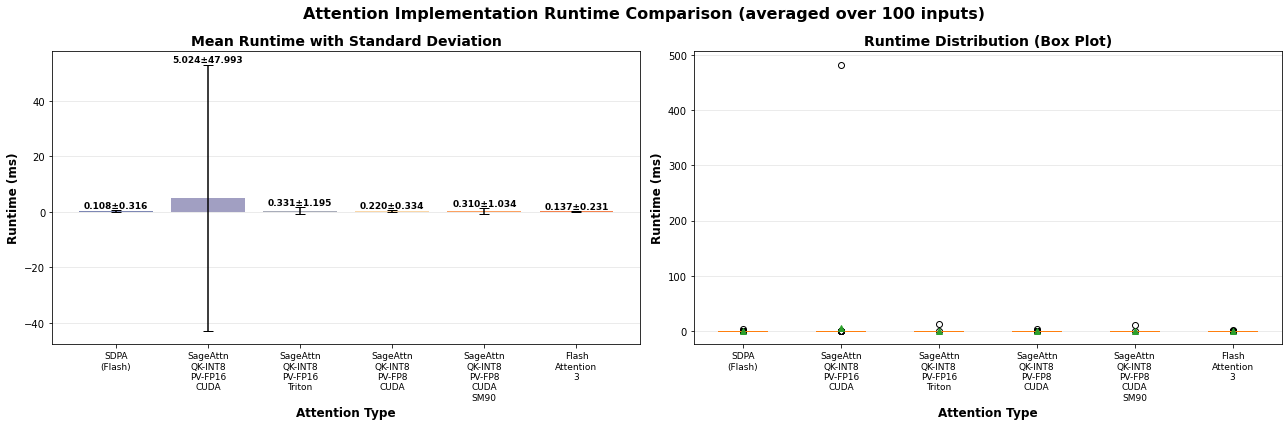

Runtime plots generated successfully!


In [4]:
# Create runtime comparison plot
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(18, 6))
fig.suptitle(f'Attention Implementation Runtime Comparison (averaged over {num_inputs} inputs)', 
             fontsize=16, fontweight='bold')

names = list(mean_runtimes.keys())
colors = ['#485696', '#7a77a9', '#858a9d', '#f9c784', '#fc7a1e', '#f24c00']

# Plot 1: Mean runtime with error bars (std)
mean_times = [mean_runtimes[name]['mean_ms'] for name in names]
std_times = [mean_runtimes[name]['std_ms'] for name in names]

bars = ax1.bar(range(len(names)), mean_times, yerr=std_times, capsize=5, color=colors, alpha=0.7)
ax1.set_xlabel('Attention Type', fontweight='bold', fontsize=12)
ax1.set_ylabel('Runtime (ms)', fontweight='bold', fontsize=12)
ax1.set_title('Mean Runtime with Standard Deviation', fontsize=14, fontweight='bold')
ax1.set_xticks(range(len(names)))
ax1.set_xticklabels([name.replace(' ', '\n') for name in names], rotation=0, ha='center', fontsize=9)
ax1.grid(axis='y', alpha=0.3)

# Add value labels on bars
for i, (bar, val, std) in enumerate(zip(bars, mean_times, std_times)):
    height = bar.get_height()
    ax1.text(bar.get_x() + bar.get_width()/2., height + std,
             f'{val:.3f}±{std:.3f}', ha='center', va='bottom', fontsize=9, fontweight='bold')

# Plot 2: Box plot showing distribution
runtime_data = [all_runtimes[name] for name in names]
bp = ax2.boxplot(runtime_data, labels=[name.replace(' ', '\n') for name in names], 
                  patch_artist=True, showmeans=True)

# Color the box plots
for patch, color in zip(bp['boxes'], colors):
    patch.set_facecolor(color)
    patch.set_alpha(0.7)

ax2.set_xlabel('Attention Type', fontweight='bold', fontsize=12)
ax2.set_ylabel('Runtime (ms)', fontweight='bold', fontsize=12)
ax2.set_title('Runtime Distribution (Box Plot)', fontsize=14, fontweight='bold')
ax2.grid(axis='y', alpha=0.3)

plt.setp(ax2.xaxis.get_majorticklabels(), fontsize=9, ha='center')

plt.tight_layout()
plt.show()

print("Runtime plots generated successfully!")


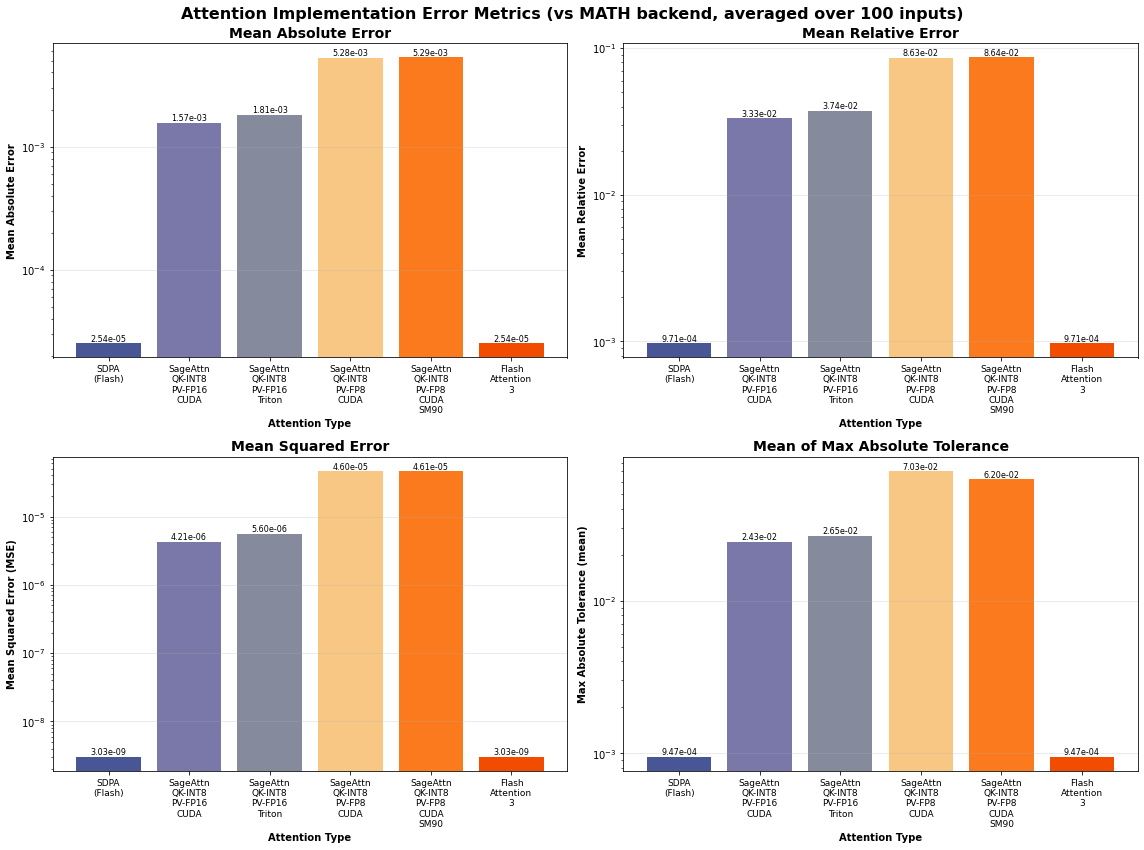

Barplots generated successfully!


In [8]:
# Create barplots for key metrics
fig, axes = plt.subplots(2, 2, figsize=(16, 12))
fig.suptitle('Attention Implementation Error Metrics (vs MATH backend, averaged over 100 inputs)', 
             fontsize=16, fontweight='bold')

# Prepare data for plotting
names = list(mean_metrics.keys())
colors = ['#485696', '#7a77a9', '#858a9d', '#f9c784', '#fc7a1e', '#f24c00']

# Metric 1: Mean Absolute Error
ax1 = axes[0, 0]
mean_abs_errors = [mean_metrics[name]['mean_absolute_tolerance'] for name in names]
bars1 = ax1.bar(range(len(names)), mean_abs_errors, color=colors)
ax1.set_xlabel('Attention Type', fontweight='bold')
ax1.set_ylabel('Mean Absolute Error', fontweight='bold')
ax1.set_title('Mean Absolute Error', fontsize=14, fontweight='bold')
ax1.set_xticks(range(len(names)))
ax1.set_xticklabels([name.replace(' ', '\n') for name in names], rotation=0, ha='center', fontsize=9)
ax1.grid(axis='y', alpha=0.3)
ax1.set_yscale('log')
# Add value labels on bars
for i, (bar, val) in enumerate(zip(bars1, mean_abs_errors)):
    height = bar.get_height()
    ax1.text(bar.get_x() + bar.get_width()/2., height,
             f'{val:.2e}', ha='center', va='bottom', fontsize=8)

# Metric 2: Mean Relative Error
ax2 = axes[0, 1]
mean_rel_errors = [mean_metrics[name]['mean_relative_tolerance'] for name in names]
bars2 = ax2.bar(range(len(names)), mean_rel_errors, color=colors)
ax2.set_xlabel('Attention Type', fontweight='bold')
ax2.set_ylabel('Mean Relative Error', fontweight='bold')
ax2.set_title('Mean Relative Error', fontsize=14, fontweight='bold')
ax2.set_xticks(range(len(names)))
ax2.set_xticklabels([name.replace(' ', '\n') for name in names], rotation=0, ha='center', fontsize=9)
ax2.grid(axis='y', alpha=0.3)
ax2.set_yscale('log')
for i, (bar, val) in enumerate(zip(bars2, mean_rel_errors)):
    height = bar.get_height()
    ax2.text(bar.get_x() + bar.get_width()/2., height,
             f'{val:.2e}', ha='center', va='bottom', fontsize=8)

# Metric 3: MSE
ax3 = axes[1, 0]
mse_values = [mean_metrics[name]['mse'] for name in names]
bars3 = ax3.bar(range(len(names)), mse_values, color=colors)
ax3.set_xlabel('Attention Type', fontweight='bold')
ax3.set_ylabel('Mean Squared Error (MSE)', fontweight='bold')
ax3.set_title('Mean Squared Error', fontsize=14, fontweight='bold')
ax3.set_xticks(range(len(names)))
ax3.set_xticklabels([name.replace(' ', '\n') for name in names], rotation=0, ha='center', fontsize=9)
ax3.grid(axis='y', alpha=0.3)
ax3.set_yscale('log')
for i, (bar, val) in enumerate(zip(bars3, mse_values)):
    height = bar.get_height()
    ax3.text(bar.get_x() + bar.get_width()/2., height,
             f'{val:.2e}', ha='center', va='bottom', fontsize=8)

# Metric 4: Max Absolute Tolerance
ax4 = axes[1, 1]
max_abs_tolerance = [mean_metrics[name]['max_absolute_tolerance'] for name in names]
bars4 = ax4.bar(range(len(names)), max_abs_tolerance, color=colors)
ax4.set_xlabel('Attention Type', fontweight='bold')
ax4.set_ylabel('Max Absolute Tolerance (mean)', fontweight='bold')
ax4.set_title('Mean of Max Absolute Tolerance', fontsize=14, fontweight='bold')
ax4.set_xticks(range(len(names)))
ax4.set_xticklabels([name.replace(' ', '\n') for name in names], rotation=0, ha='center', fontsize=9)
ax4.grid(axis='y', alpha=0.3)
ax4.set_yscale('log')
for i, (bar, val) in enumerate(zip(bars4, max_abs_tolerance)):
    height = bar.get_height()
    ax4.text(bar.get_x() + bar.get_width()/2., height,
             f'{val:.2e}', ha='center', va='bottom', fontsize=8)

plt.tight_layout()
plt.show()

print("Barplots generated successfully!")


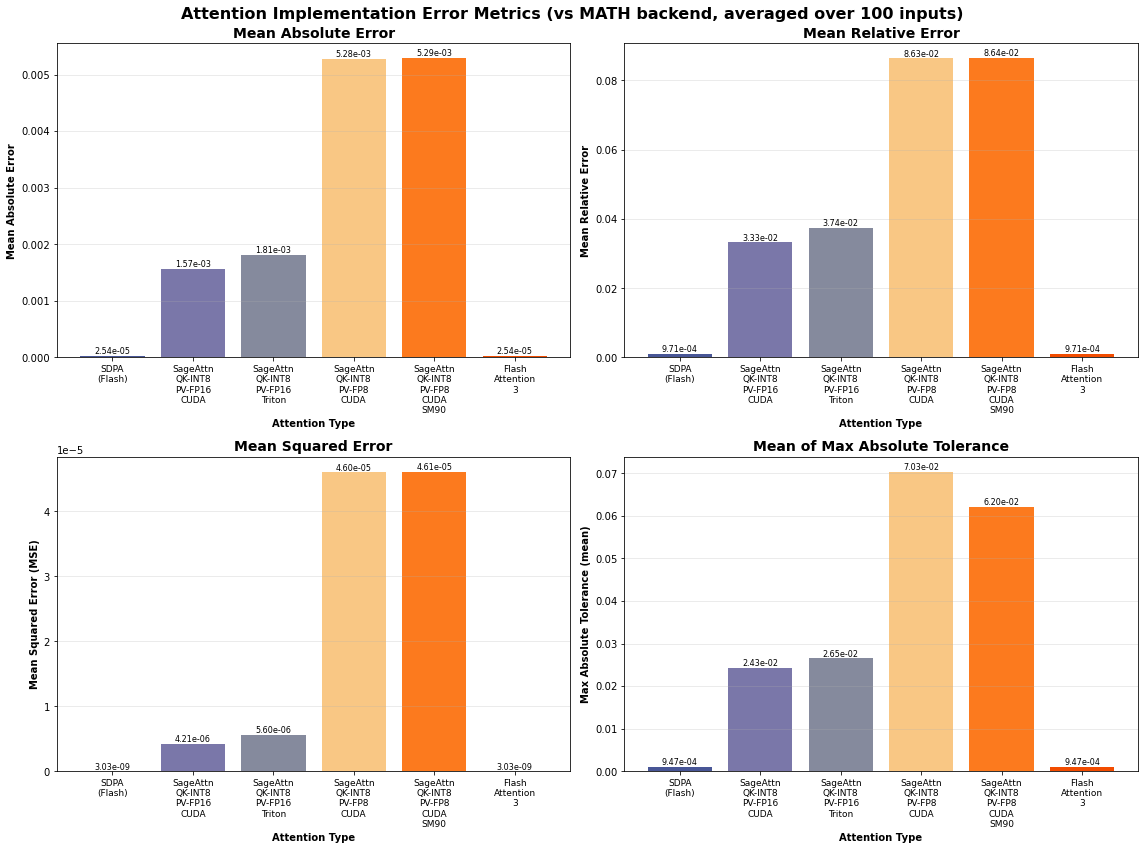

Barplots generated successfully!


In [9]:
# Create barplots for key metrics
fig, axes = plt.subplots(2, 2, figsize=(16, 12))
fig.suptitle('Attention Implementation Error Metrics (vs MATH backend, averaged over 100 inputs)', 
             fontsize=16, fontweight='bold')

# Prepare data for plotting
names = list(mean_metrics.keys())
colors = ['#485696', '#7a77a9', '#858a9d', '#f9c784', '#fc7a1e', '#f24c00']

# Metric 1: Mean Absolute Error
ax1 = axes[0, 0]
mean_abs_errors = [mean_metrics[name]['mean_absolute_tolerance'] for name in names]
bars1 = ax1.bar(range(len(names)), mean_abs_errors, color=colors)
ax1.set_xlabel('Attention Type', fontweight='bold')
ax1.set_ylabel('Mean Absolute Error', fontweight='bold')
ax1.set_title('Mean Absolute Error', fontsize=14, fontweight='bold')
ax1.set_xticks(range(len(names)))
ax1.set_xticklabels([name.replace(' ', '\n') for name in names], rotation=0, ha='center', fontsize=9)
ax1.grid(axis='y', alpha=0.3)
# ax1.set_yscale('log')
# Add value labels on bars
for i, (bar, val) in enumerate(zip(bars1, mean_abs_errors)):
    height = bar.get_height()
    ax1.text(bar.get_x() + bar.get_width()/2., height,
             f'{val:.2e}', ha='center', va='bottom', fontsize=8)

# Metric 2: Mean Relative Error
ax2 = axes[0, 1]
mean_rel_errors = [mean_metrics[name]['mean_relative_tolerance'] for name in names]
bars2 = ax2.bar(range(len(names)), mean_rel_errors, color=colors)
ax2.set_xlabel('Attention Type', fontweight='bold')
ax2.set_ylabel('Mean Relative Error', fontweight='bold')
ax2.set_title('Mean Relative Error', fontsize=14, fontweight='bold')
ax2.set_xticks(range(len(names)))
ax2.set_xticklabels([name.replace(' ', '\n') for name in names], rotation=0, ha='center', fontsize=9)
ax2.grid(axis='y', alpha=0.3)
# ax2.set_yscale('log')
for i, (bar, val) in enumerate(zip(bars2, mean_rel_errors)):
    height = bar.get_height()
    ax2.text(bar.get_x() + bar.get_width()/2., height,
             f'{val:.2e}', ha='center', va='bottom', fontsize=8)

# Metric 3: MSE
ax3 = axes[1, 0]
mse_values = [mean_metrics[name]['mse'] for name in names]
bars3 = ax3.bar(range(len(names)), mse_values, color=colors)
ax3.set_xlabel('Attention Type', fontweight='bold')
ax3.set_ylabel('Mean Squared Error (MSE)', fontweight='bold')
ax3.set_title('Mean Squared Error', fontsize=14, fontweight='bold')
ax3.set_xticks(range(len(names)))
ax3.set_xticklabels([name.replace(' ', '\n') for name in names], rotation=0, ha='center', fontsize=9)
ax3.grid(axis='y', alpha=0.3)
# ax3.set_yscale('log')
for i, (bar, val) in enumerate(zip(bars3, mse_values)):
    height = bar.get_height()
    ax3.text(bar.get_x() + bar.get_width()/2., height,
             f'{val:.2e}', ha='center', va='bottom', fontsize=8)

# Metric 4: Max Absolute Tolerance
ax4 = axes[1, 1]
max_abs_tolerance = [mean_metrics[name]['max_absolute_tolerance'] for name in names]
bars4 = ax4.bar(range(len(names)), max_abs_tolerance, color=colors)
ax4.set_xlabel('Attention Type', fontweight='bold')
ax4.set_ylabel('Max Absolute Tolerance (mean)', fontweight='bold')
ax4.set_title('Mean of Max Absolute Tolerance', fontsize=14, fontweight='bold')
ax4.set_xticks(range(len(names)))
ax4.set_xticklabels([name.replace(' ', '\n') for name in names], rotation=0, ha='center', fontsize=9)
ax4.grid(axis='y', alpha=0.3)
# ax4.set_yscale('log')
for i, (bar, val) in enumerate(zip(bars4, max_abs_tolerance)):
    height = bar.get_height()
    ax4.text(bar.get_x() + bar.get_width()/2., height,
             f'{val:.2e}', ha='center', va='bottom', fontsize=8)

plt.tight_layout()
plt.show()

print("Barplots generated successfully!")


In [7]:
# Create a summary comparison table
import pandas as pd

summary_data = []
for name, metrics in mean_metrics.items():
    row = {
        'Attention Type': name,
        'Mean Runtime (ms)': f"{mean_runtimes[name]['mean_ms']:.4f}" if name in mean_runtimes else 'N/A',
        'Std Runtime (ms)': f"{mean_runtimes[name]['std_ms']:.4f}" if name in mean_runtimes else 'N/A',
        'Mean Abs Error': f"{metrics['mean_absolute_tolerance']:.6e}",
        'Mean Rel Error': f"{metrics['mean_relative_tolerance']:.6e}",
        'MSE': f"{metrics['mse']:.6e}",
        'Max Abs Tolerance': f"{metrics['max_absolute_tolerance']:.6e}",
        'Max Rel Tolerance': f"{metrics['max_relative_tolerance']:.6e}",
    }
    summary_data.append(row)

pd.DataFrame(summary_data)


,Attention Type,Mean Runtime (ms),Std Runtime (ms),Mean Abs Error,Mean Rel Error,MSE,Max Abs Tolerance,Max Rel Tolerance
0,SDPA (Flash),0.1078,0.3156,2.536206e-05,9.707840e-04,3.027220e-09,9.472656e-04,1.958950e+00
1,SageAttn QK-INT8 PV-FP16 CUDA,5.0245,47.9926,1.568080e-03,3.326230e-02,4.213332e-06,2.425812e-02,1.999416e+00
2,SageAttn QK-INT8 PV-FP16 Triton,0.3310,1.1954,1.810164e-03,3.736821e-02,5.599509e-06,2.653595e-02,1.999536e+00
3,SageAttn QK-INT8 PV-FP8 CUDA,0.2200,0.3340,5.282955e-03,8.630530e-02,4.595685e-05,7.033081e-02,1.999910e+00
4,SageAttn QK-INT8 PV-FP8 CUDA SM90,0.3097,1.0341,5.290417e-03,8.640017e-02,4.605384e-05,6.204712e-02,1.999901e+00
5,Flash Attention 3,0.1370,0.2310,2.536210e-05,9.707830e-04,3.027246e-09,9.472656e-04,1.958820e+00
